<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Workshop SWDB 2022 </h1> 
<h3 align="center">Tuesday, August 23rd, 2022</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Receptive Field Analysis </h2>

This notebook will demonstrate how to get receptive field information for the units in the Visual Behavior Neuropixels dataset. In the visual system, a neuron's receptive field is the region of visual space where a stimulus will drive spiking activity. Because this is a fundamental property of visual neurons, we have included a tool to help characterize the receptive fields of neurons in this dataset. 

</div>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)

%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [261]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> How do we define a receptive field for this dataset? </h2>

To characterize receptive fields, we presented gabor stimuli in a 9x9 grid as depicted below. Further analysis followed the convention described for the <a href="https://www.nature.com/articles/s41586-020-03171-x/figures/10">Visual Coding Neuropixels paper</a>, which used the same stimulus (with minor differences in the temporal and spatial frequency of the gabors). This workflow is diagrammed below. See also the <a href="https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html">Visual Coding receptive field tutorial</a> for more info about the stimulus.
    
</div>

<img src="../resources/rf_explanation.PNG"/>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We've made a convenience class to handle calculating the RFs for each unit, as well as metrics describing RF shape, position and significance. 
    
</div>

In [262]:
from brain_observatory_utilities.datasets.electrophysiology.receptive_field_mapping import ReceptiveFieldMapping_VBN

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

You can filter which units you'd like to calculate rf metrics for by using the <code>filter</code> argument.
    
</div>

In [263]:
#grab rf info for specific units by passing a list of unit_ids
rf = ReceptiveFieldMapping_VBN(session, filter=[1061854534,])

In [264]:
#you can also pass in a dictionary. We can replicate the cell above using the 'unit_id' key:
rf = ReceptiveFieldMapping_VBN(session, filter={'unit_id': [1061854534,]})

In [265]:
#you can also filter by brain area (structure_acronym), or any column in the session.get_units() dataframe
#the following will return rf info for 'good' units in VISp
rf = ReceptiveFieldMapping_VBN(session, filter={'structure_acronym': 'VISp', 'quality':'good'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can use this object to compute a dataframe with a number of helpful metrics that describe the receptive field for each unit (note: if you're passing in a long list of units this will take a few minutes to run):
    
</div>

In [266]:
rf_metrics = rf.metrics
rf_metrics.head(3)

c:\users\svc_ccg\documents\github\allensdk\allensdk\brain_observatory\ecephys\stimulus_analysis\receptive_field_mapping.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stim_table.loc[:, self._col_pos_y] = 40.0 - self.stim_table[self._col_pos_y]


,azimuth_rf,elevation_rf,width_rf,height_rf,area_rf,p_value_rf,on_screen_rf,is_inverted
unit_id,,,,,,,,
1061854534,55.0,15.0,11.389664,17.895142,400.0,0.0,True,False
1061854526,51.0,30.0,23.659511,16.982601,1000.0,0.0,True,False
1061854501,50.0,20.0,13.767715,17.064479,100.0,0.0,True,False


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at what each of these columns means:

<b>The following metrics are based on a thresholded receptive field</b>: to get the thresholded rf, the following steps are taken:
<ol>
    <li> the raw receptive field (rf) is calculated by summing the spikes evoked by each spatial position of the gabor stimulus. This yields a 9X9 matrix of spike counts. </li>
    <li> the raw rf is filtered with a gaussian (sigma of 10 degrees or one pixel) to produce rf_smooth </li> 
    <li> a threshold is determined as max(rf_smooth) - standard_deviation(rf_smooth)*0.5 </li> 
    <li> rf_smooth is binarized by setting values below threshold to False and above to True, producing rf_thresh </li> 
    <li> rf_thresh is labeled (scipy.ndimage.label) and the label over which rf_smooth is maximized is found. Pixels associated with this label are set to 1, and all other labeled regions are set to 0. This step produces the final rf_thresh used for analysis. </li> 
</ol>   
<p><code>azimuth_rf</code>: The location of the center of mass of rf_thresh in azimuth. Units are degrees.  
<p><code>elevation_rf</code>: The location of the center of mass of rf_thresh in elevation. Units are degrees.  
<p><code>area_rf</code>: The count of non-zero elements in rf_thresh multiplied by 100 degrees<sup>2</sup>. Units are degrees<sup>2</sup>.  

<p><b>The following metrics are based on a 2D gaussian fit to the raw rf:</b>  
<p><code>width_rf</code> : the sigma of the 2D gaussian fit in the azimuth dimension in degrees  
<p><code>height_rf</code>: the sigma of the 2D gaussian fit in the elevation dimension in degrees  
<p><code>on_screen_rf</code>: True if the center of the 2D gaussian fit fell within the region of visual space spanned by the gabor stimuli. False if the center of the 2D gaussian fell outside this region.  
<p><code>is_inverted</code>:  True if the peak of the gaussian fit is negative, indicating a neuron that is suppressed by visual contrast. For these neurons, the rf is inverted and metrics are recalculated. 

<p>The `p_value` was calculated by a chi-square test as described <a href="https://www.nature.com/articles/s41586-020-03171-x?WT.ec_id=NATURE-202101&sap-outbound-id=4E195E023D51C73B5BD9070E527199209B14C6B0#Sec5">here</a>  

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can also use this object to get a receptive field for an individual unit. This will come back as a 9x9 numpy array with spike counts for all 81 possible positions for the gabor stimulus.
    
</div>

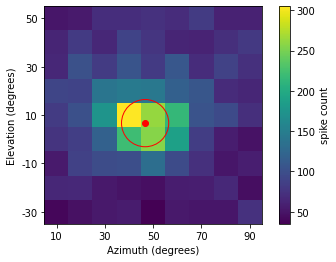

In [248]:
# get the rf for the first unit
unit_id = 1061854534
unit_rf = rf.get_receptive_field(unit_id)

# plot it
fig, ax = plt.subplots()
im = ax.imshow(unit_rf)
plt.colorbar(im, label='spike count')

# convert ticks to degrees: the center of the screen is at 50 degrees azimuth and 10 degrees elevation
tick_positions = np.arange(0, 10, 2)
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_positions*10 + 10)
ax.set_yticklabels(tick_positions[::-1]*10-30) #invert elevation labels for imshow origin convention
ax.set_xlabel('Azimuth (degrees)')
ax.set_ylabel('Elevation (degrees)')

# now let's plot the center of the rf from the rf metrics table
# first we need to get the azimuth and elevation coords
unit_metrics = rf_metrics.loc[unit_id]
azi = unit_metrics.azimuth_rf
ele = unit_metrics.elevation_rf

# then we need to convert these to pixels to plot
azi_coord = lambda x: (x-50)/10 + 4
ele_coord = lambda x: 8 - ((x-10)/10 + 4)

# and plot the center
ax.plot(azi_coord(azi), ele_coord(ele), 'ro')

# as a sanity check, let's plot a circle with the same area as our rf for comparison
unit_rf_area = unit_metrics.area_rf
radius = (0.01*unit_rf_area/np.pi)**0.5
area_circle = plt.Circle((azi_coord(azi), ele_coord(ele)), radius=radius, fill=False, color='r')
ax.add_patch(area_circle)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's loop through our units and plot all of their RFs:
    
</div>

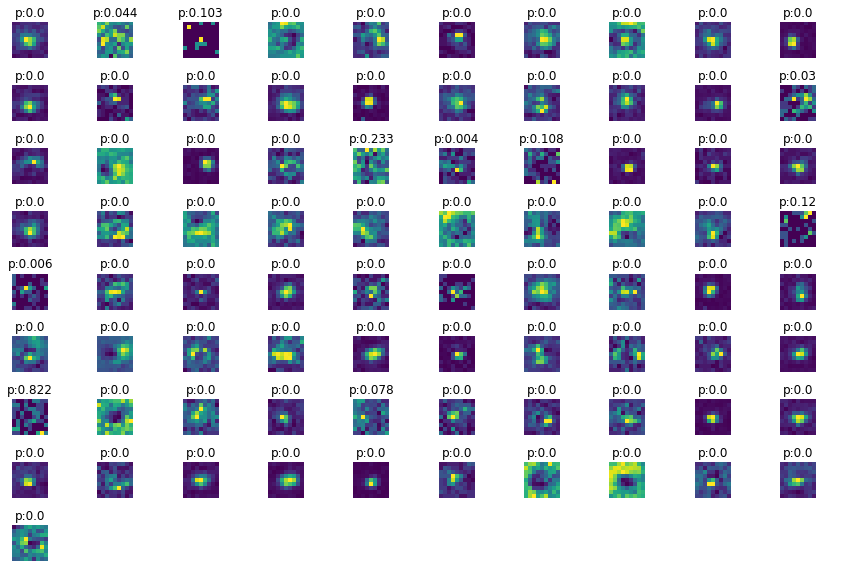

In [254]:
fig, axes = plt.subplots(int(len(rf_metrics)/10)+1, 10)
fig.set_size_inches(12, 8)
for uind, uid in enumerate(rf_metrics.index.values):
    unitrf = rf.get_receptive_field(uid)
    pval = rf_metrics.loc[uid]['p_value_rf']
    ax_row = int(uind/10)
    ax_col = uind%10
    axes[ax_row][ax_col].imshow(unitrf)
    axes[ax_row][ax_col].set_title(f"p:{pval}")
                         
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we can merge our receptive field stats into the units dataframe. This will make it easy to run subsequent analysis that might require units to meet RF criteria
    
</div>

In [257]:
units = session.get_units()
units_with_rfstats = units.merge(rf_metrics, left_index=True, right_on='unit_id')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For example, we could use this new dataframe to get a list of units with a <code>good</code> quality label and a significant rf p value:
    
</div>

In [260]:
good_rf_units = units_with_rfstats[(units_with_rfstats.quality=='good') &
                                  (units_with_rfstats.p_value_rf<0.01)]
good_rf_units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,velocity_below,waveform_duration,azimuth_rf,elevation_rf,width_rf,height_rf,area_rf,p_value_rf,on_screen_rf,is_inverted
unit_id,,,,,,,,,,,,,,,,,,,,,
1068224066,0.505749,427.309350,0.001876,176,111.67,4.153344,11.634204,0.010059,57.525935,0.021061,...,0.206030,0.206030,46.667,6.667,9.965685,13.607393,300.0,0.0,True,False
1068224050,0.362399,196.753830,0.168506,162,176.80,3.473079,6.773801,0.031370,70.104553,0.001629,...,-0.343384,0.508208,45.000,50.000,2.715169,18.272095,200.0,0.0,True,False
1068224099,0.312275,141.384750,0.436553,209,275.06,3.262882,4.710847,0.201591,64.974523,0.005909,...,0.412060,0.810385,73.333,13.333,14.446510,9.641028,300.0,0.0,True,False
1068224098,0.389366,289.158285,0.000157,208,213.50,5.903763,2.549296,0.065853,60.218737,0.004454,...,0.206030,0.700503,55.000,15.000,6.478704,8.235246,400.0,0.0,True,False
1068224054,0.547314,168.887745,0.500000,165,274.75,2.202116,5.284472,0.488961,51.062796,0.012287,...,0.073582,0.645561,56.667,13.333,14.601747,15.530920,300.0,0.0,True,False
